Homography Matrix (RANSAC):
[[ 7.54616284e-01  1.80631008e-01  1.29766067e+02]
 [ 3.19140915e-01  1.52249984e+00 -5.23169152e+01]
 [ 1.04375395e-03  5.36928549e-04  1.00000000e+00]]
Homography Matrix (Dataset):
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


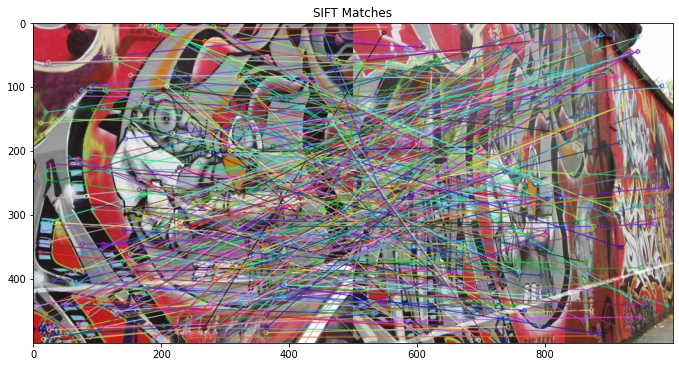

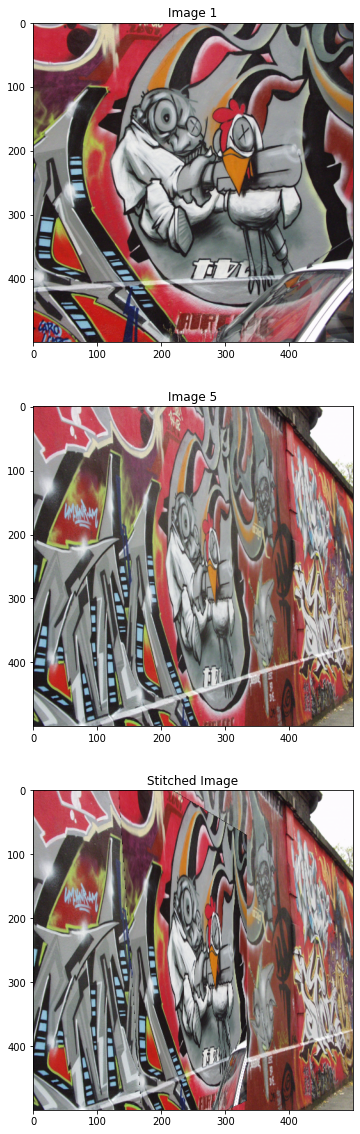

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_homography(src_pts, dst_pts):
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0], src_pts[i][1]
        u, v = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    h = V[-1, :].reshape((3, 3))
    return h / h[2, 2]

def apply_homography(points, homography):
    points = np.column_stack((points, np.ones((len(points), 1), dtype=np.float32)))
    transformed_points = np.dot(homography, points.T).T
    transformed_points /= transformed_points[:, 2][:, None]
    return transformed_points[:, :2]

def find_homography_ransac(src_pts, dst_pts, num_iterations=100000, threshold=5.0):
    best_homography = None
    best_inliers = 0

    for _ in range(num_iterations):
        # Randomly sample 4 correspondences
        sample_indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[sample_indices]
        dst_sample = dst_pts[sample_indices]
        # Compute the homography for the sampled correspondences
        homography = compute_homography(src_sample, dst_sample)
        # Transform all points from src to estimate the corresponding points in dst
        transformed_src_pts = apply_homography(src_pts, homography)
        # Compute the Euclidean distance between the transformed points and the actual dst points
        distances = np.linalg.norm(transformed_src_pts - dst_pts, axis=-1)
        # Count the inliers (points with distance less than the threshold)
        inliers = np.sum(distances < threshold)

        # Update the best homography if the current one has more inliers
        if inliers > best_inliers:
            best_inliers = inliers
            best_homography = homography

    return best_homography

# Load the images
img1_r = cv2.imread('img1.ppm')
img5_r = cv2.imread('img5.ppm')
img1 = cv2.cvtColor(img1_r, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5_r, cv2.COLOR_BGR2RGB)

# Resize images to a common size
common_size = (500, 500)
img1_resized = cv2.resize(img1, common_size)
img5_resized = cv2.resize(img5, common_size)

# Step (a): Compute and match SIFT features
#sift = cv2.SIFT_create()
sift = cv2.SIFT_create(nfeatures=5000)
# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_resized, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5_resized, None)
# Use a brute force matcher to find the best matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append(m)

# Draw the matches using Matplotlib
img_matches = cv2.drawMatches(img1_resized, keypoints1, img5_resized, keypoints5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(40, 20))
plt.subplot(3, 1, 1), plt.imshow(img_matches), plt.title('SIFT Matches')

# Step (b): Compute the homography using RANSAC
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Use RANSAC to estimate the homography
    homography = find_homography_ransac(src_pts.squeeze(), dst_pts.squeeze())

    # Print the computed homography matrix
    print("Homography Matrix (RANSAC):")
    print(homography)

    # Homography Given in the File
    dataset_homography = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                                    [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                                    [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])
    print("Homography Matrix (Dataset):")
    print(dataset_homography)
else:
    print("Not enough matches to compute homography.")

# Step (c): Stitch img1 onto img5 using the computed homography
if homography is not None:

    # Warp the image using the homography
    img1_warped = cv2.warpPerspective(img1_resized, homography, common_size)
    # Combine the images
    result = img5_resized.copy()
    result[img1_warped > 0] = img1_warped[img1_warped > 0]

    plt.figure(figsize=(40, 20))
    # Display the images
    plt.subplot(3, 1, 1), plt.imshow(img1_resized), plt.title('Image 1')
    plt.subplot(3, 1, 2), plt.imshow(img5_resized), plt.title('Image 5')
    plt.subplot(3, 1, 3), plt.imshow(result), plt.title('Stitched Image')
    plt.show()
else:
    print("Homography not computed, cannot perform stitching.")
